
## ETA Performance 

**Created:** 2025-11-08

This notebook is a **source of truth** for validating the performance degradation claim and for producing reproducible anomaly/attribution outputs from `cleaned_eta_logs.csv`.

> The original dataset was collected from raw logs in `time.txt` and `time6.txt`. It has been cleaned (normalizing fields) and time ordered to ensure accurate analysis. 

> **Data file SHA256:** `b7c4fe3646d472cf92b9221abd54302fb82712f5969e9dabb942b2f459dabacd`

### Windows used in verification:

**Baseline:** 2025-11-06 21:30 → 22:00
**Peak:** 2025-11-06 22:20 → 23:10


## Analysis Scope with Clean Data:
- **Reported Issue**: Slowness and timeout observed at 19:10 UTC (6 Nov 2025)
- **Local Time**: 22:10 UTC+3 (6 Nov 2025)
- **Analysis Period**: 21:00 - 23:59 (6 Nov) + 00:00 - 03:30 (7 Nov)
- **Main Incident Window**: 22:10 → 04:39 Local (19:10 → 01:39 UTC) Last available record
  

## Environment & Requirements

- Python 3.9+
- `pandas`, `matplotlib` and `seaborn`

> All charts are generated with `matplotlib`; no internet access is required.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime
import hashlib, platform, json
import hashlib, pathlib, json

# DATA_PATH = pathlib.Path("datasets/cleaned_eta_logs.csv")
# sha = hashlib.sha256(DATA_PATH.read_bytes()).hexdigest()
# print("Dataset:", DATA_PATH.name)
# print("SHA256 :", sha)

## Save the hash into verification artifact

In [27]:

plt.style.use('seaborn-v0_8')
pd.options.display.max_rows = 50

CSV_PATH = 'datasets/cleaned_eta_logs.csv'

# Lock to dataset hash (for audit trail)
sha = hashlib.sha256(open(CSV_PATH,'rb').read()).hexdigest()
print('Dataset:', CSV_PATH)
print('SHA256 :', sha)
print('Python :', platform.python_version())
print('Pandas :', pd.__version__)


Dataset: datasets/cleaned_eta_logs.csv
SHA256 : b7c4fe3646d472cf92b9221abd54302fb82712f5969e9dabb942b2f459dabacd
Python : 3.12.11
Pandas : 2.2.3


## Load data

In [28]:
df = pd.read_csv(CSV_PATH)
assert 'datetime' in df.columns and 'execution_time' in df.columns, 'CSV must contain datetime and execution_time columns'

df['datetime'] = pd.to_datetime(df['datetime'])
# Normalize boolean flags if present
for col in ['is_slow','is_very_slow','is_critical']:
    if col in df.columns and df[col].dtype != bool:
        df[col] = df[col].astype(str).str.lower().map({'true':True,'false':False})

print('Rows   :', len(df))
print('Start  :', df['datetime'].min())
print('End    :', df['datetime'].max())
print('Agents :', df['agent_type'].nunique(), sorted(df['agent_type'].unique()))


Rows   : 158186
Start  : 2025-11-06 00:00:00.850000
End    : 2025-11-07 03:33:49.509000
Agents : 2 ['eta_agent', 'eta_iagent']


## Parameters — Baseline/Peak Windows (Start, End)


In [29]:
baseline_start = datetime(2025, 11, 6, 21, 30)
baseline_end   = datetime(2025, 11, 6, 22, 0)
peak_start     = datetime(2025, 11, 6, 22, 20)
peak_end       = datetime(2025, 11, 6, 23, 10)

print('Baseline :', baseline_start, '->', baseline_end)
print('Peak     :', peak_start, '->', peak_end)


Baseline : 2025-11-06 21:30:00 -> 2025-11-06 22:00:00
Peak     : 2025-11-06 22:20:00 -> 2025-11-06 23:10:00


## Standard Deviation Formula:
### σ = √(Σ(x-μ)²/n) (population std)

## Verification | Baseline vs Peak

In [30]:
baseline = df[(df['datetime'] >= baseline_start) & (df['datetime'] < baseline_end)]
peak     = df[(df['datetime'] >= peak_start)     & (df['datetime'] < peak_end)]

print(f'Baseline count: {len(baseline):,}')
print(f'Peak count    : {len(peak):,}')

def stats(s: pd.DataFrame):
    return {
        'count': int(len(s)),
        'time_min': str(s['datetime'].min()),
        'time_max': str(s['datetime'].max()),
        'mean': float(s['execution_time'].mean()),
        'median': float(s['execution_time'].median()),
        'p95': float(s['execution_time'].quantile(0.95)),
        'std': float(s['execution_time'].std(ddof=0)),  # std population
        'min': float(s['execution_time'].min()),
        'max': float(s['execution_time'].max()),
        'slow_pct_gt20': float((s['execution_time'] > 20).mean() * 100.0),
        'critical_pct_gt60': float((s['execution_time'] > 60).mean() * 100.0),
    }

b = stats(baseline)
p = stats(peak)

print("\nBaseline metrics:")
print(json.dumps(b, indent=2))

print("\nPeak metrics:")
print(json.dumps(p, indent=2))

slowdown = p['mean'] / b['mean'] if b['mean'] else np.nan
increase = ((p['mean'] - b['mean']) / b['mean'] * 100.0) if b['mean'] else np.nan

print(f"\nSlowdown factor (mean): {slowdown:.2f}x")
print(f"Increase vs baseline : {increase:.2f}%")

# Persist exact results for reports
verification = {
    'baseline_window': {'start': str(baseline_start), 'end': str(baseline_end)},
    'peak_window': {'start': str(peak_start), 'end': str(peak_end)},
    'baseline': b,
    'peak': p,
    'slowdown_factor_mean': round(float(slowdown), 3) if np.isfinite(slowdown) else None,
    'increase_percent_mean': round(float(increase), 2) if np.isfinite(increase) else None,
    'dataset_sha256': sha,  # assumes 'sha' was set earlier when you hashed the CSV
}
#with open('artifact_verification_case.json', 'w') as f:
 #   f.write(json.dumps(verification, indent=2))
#print("\nSaved -> artifact_verification_case.json")


Baseline count: 2,756
Peak count    : 4,708

Baseline metrics:
{
  "count": 2756,
  "time_min": "2025-11-06 21:30:04.074000",
  "time_max": "2025-11-06 21:59:59.654000",
  "mean": 2.0268011611030476,
  "median": 0.901,
  "p95": 7.3420000000000005,
  "std": 2.879717509468294,
  "min": 0.027,
  "max": 34.083,
  "slow_pct_gt20": 0.39912917271407833,
  "critical_pct_gt60": 0.0
}

Peak metrics:
{
  "count": 4708,
  "time_min": "2025-11-06 22:20:00.187000",
  "time_max": "2025-11-06 23:09:59.259000",
  "mean": 13.186807986406118,
  "median": 11.792,
  "p95": 35.74714999999994,
  "std": 13.158711419893468,
  "min": 0.021,
  "max": 115.895,
  "slow_pct_gt20": 16.90739167374681,
  "critical_pct_gt60": 1.6992353440951573
}

Slowdown factor (mean): 6.51x
Increase vs baseline : 550.62%


## Attribution | by agent & top PIDs during peak

In [31]:
by_agent_base = baseline.groupby('agent_type').execution_time.agg(
    count='size', mean='mean', median='median', p95=lambda s: s.quantile(0.95), max='max'
)
by_agent_peak = peak.groupby('agent_type').execution_time.agg(
    count='size', mean='mean', median='median', p95=lambda s: s.quantile(0.95), max='max'
)

display(by_agent_base.round(3))
display(by_agent_peak.round(3))

peak2 = peak.copy()
peak2['exec_time'] = peak2['execution_time']
pid_contrib = peak2.groupby(['agent_type','pid']).agg(
    count=('exec_time','size'),
    mean=('exec_time','mean'),
    sum_exec=('exec_time','sum'),
    max=('exec_time','max')
).sort_values('sum_exec', ascending=False)

display(pid_contrib.head(10).round(3))

by_agent_base.round(3).to_csv('artifact_baseline_by_agent.csv')
by_agent_peak.round(3).to_csv('artifact_peak_by_agent.csv')
pid_contrib.round(3).to_csv('artifact_peak_top_pid.csv')
print('Saved -> artifact_baseline_by_agent.csv, artifact_peak_by_agent.csv, artifact_peak_top_pid.csv')


,count,mean,median,p95,max
agent_type,,,,,
eta_agent,2572,2.081,0.895,7.400,34.083
eta_iagent,184,1.271,0.917,4.213,9.347


,count,mean,median,p95,max
agent_type,,,,,
eta_agent,4587,13.267,11.737,36.308,115.895
eta_iagent,121,10.159,13.136,13.335,13.978


count    mean  sum_exec     max
agent_type pid                                  
eta_agent  7963     90  14.311  1287.971  74.171
           7765     81  15.012  1215.934  89.060
           8099     78  14.705  1146.974  71.232
           7985     76  14.893  1131.898  91.333
           7864     95  11.677  1109.321  60.411
           7694     82  13.458  1103.517  77.639
           7769     78  14.087  1098.795  73.434
           7763     78  14.084  1098.550  88.380
           8109     85  12.834  1090.877  81.274
           7851     83  13.127  1089.526  68.991

Saved -> artifact_baseline_by_agent.csv, artifact_peak_by_agent.csv, artifact_peak_top_pid.csv


## Per-minute p95 anomalies with z-score

In [32]:
# Aggregate per minute
per_min = df.copy()
per_min['minute_ts'] = per_min['datetime'].dt.floor('min')
agg = per_min.groupby('minute_ts').agg(
    n=('execution_time','size'),
    mean_exec=('execution_time','mean'),
    p95_exec=('execution_time', lambda s: s.quantile(0.95)),
    max_exec=('execution_time','max')
)

# Robust z on p95
med = agg['p95_exec'].median()
mad = (agg['p95_exec']-med).abs().median()
agg['robust_z'] = 0 if mad==0 else 0.6745*(agg['p95_exec']-med)/mad

anoms = agg[agg['robust_z']>3].sort_values('p95_exec', ascending=False)
print(f"Anomalous minutes (robust_z>3): {len(anoms)}")
display(anoms.head(20).round(3))

anoms.round(4).to_csv('artifact_anomalous_minutes.csv')
print('Saved -> artifact_anomalous_minutes.csv')


Anomalous minutes (robust_z>3): 202


,n,mean_exec,p95_exec,max_exec,robust_z
minute_ts,,,,,
2025-11-06 22:16:00,110,26.574,96.951,101.467,20.939
2025-11-06 22:25:00,141,19.255,86.422,115.895,18.521
2025-11-06 23:04:00,120,23.431,81.593,104.868,17.412
2025-11-06 22:55:00,106,19.970,74.429,89.837,15.767
2025-11-06 22:14:00,94,20.589,67.076,88.746,14.078
2025-11-06 14:11:00,133,23.384,66.731,119.153,13.999
2025-11-06 22:17:00,96,20.432,64.561,97.560,13.500
2025-11-06 23:36:00,93,16.702,64.156,76.407,13.407
2025-11-06 22:24:00,116,21.240,62.708,91.333,13.075


Saved -> artifact_anomalous_minutes.csv


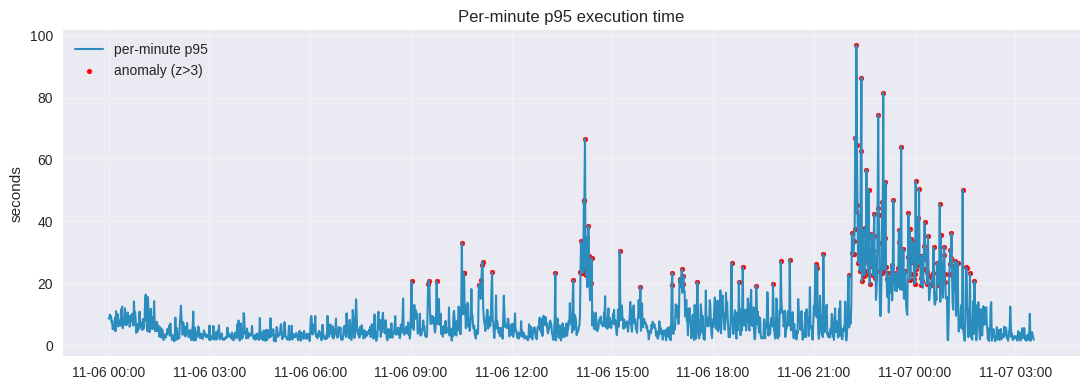

In [33]:
# Plots
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(agg.index, agg['p95_exec'], color='#2b8cbe', lw=1.5, label='per-minute p95')
if not anoms.empty:
    ax.scatter(anoms.index, anoms['p95_exec'], color='red', s=12, label='anomaly (z>3)')
ax.set_title('Per-minute p95 execution time')
ax.set_ylabel('seconds')
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

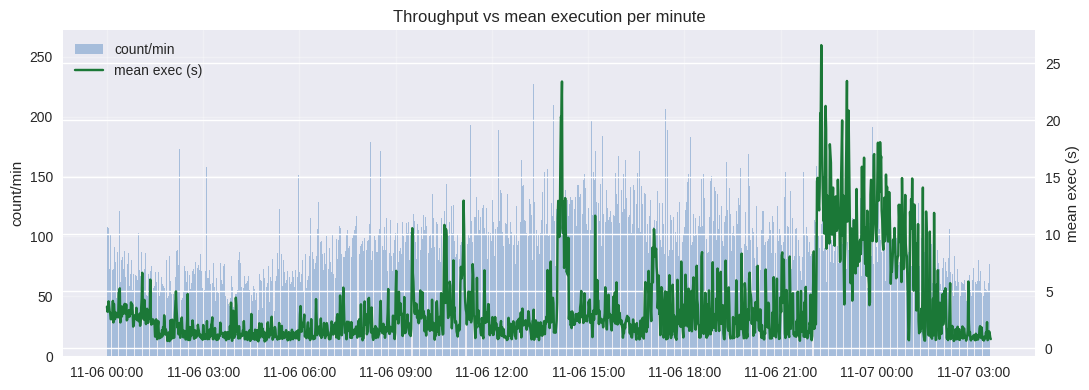

In [34]:
# Throughput vs mean exec per minute
fig, ax1 = plt.subplots(figsize=(11,4))
ax1.bar(agg.index, agg['n'], width=0.0006, color='#a6bddb', label='count/min')
ax1.set_ylabel('count/min')
ax2 = ax1.twinx()
ax2.plot(agg.index, agg['mean_exec'], color='#1b7837', label='mean exec (s)')
ax2.set_ylabel('mean exec (s)')
ax1.set_title('Throughput vs mean execution per minute')
ax1.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
# unify legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1+handles2, labels1+labels2, loc='upper left')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Top 50 slowest transactions

In [35]:
slow50 = df.nlargest(50, 'execution_time')[['datetime','agent_type','pid','transaction_id','execution_time']]
display(slow50)
slow50.to_csv('artifact_data/artifact_top50_outliers.csv', index=False)
print('Saved -> artifact_data/artifact_top50_outliers.csv')


,datetime,agent_type,pid,transaction_id,execution_time
75478,2025-11-06 14:11:30.472,eta_agent,8079,11017738838699,119.153
75477,2025-11-06 14:11:30.345,eta_agent,7695,11017738838700,118.847
75521,2025-11-06 14:11:48.334,eta_agent,7861,11017738845216,116.820
75269,2025-11-06 14:10:00.965,eta_agent,7985,11017738837744,116.548
75292,2025-11-06 14:10:09.804,eta_agent,8023,11017738837829,116.202
132539,2025-11-06 22:25:27.583,eta_agent,7860,11017739576934,115.895
132523,2025-11-06 22:25:19.082,eta_agent,7865,11017739585840,115.341
132516,2025-11-06 22:25:17.486,eta_agent,7766,11017739585838,113.754
131870,2025-11-06 22:18:33.653,eta_agent,7844,11017739567853,111.335
75535,2025-11-06 14:11:53.472,eta_agent,8097,11017738840609,109.637


Saved -> artifact_data/artifact_top50_outliers.csv


In [36]:
# Top 50 within peak window (primary)
peak = df[(df["datetime"] >= peak_start) & (df["datetime"] < peak_end)]
top50_peak = peak.nlargest(50, "execution_time")[
    ["datetime","agent_type","pid","transaction_id","execution_time"]
]
top50_peak.to_csv("artifact_data/artifact_top50_outliers_peak_window.csv", index=False)

# Global Top 50 + inside/outside peak flag (appendix)
top50_global = df.nlargest(50, "execution_time")[
    ["datetime","agent_type","pid","transaction_id","execution_time"]
]
in_peak = (top50_global["datetime"] >= peak_start) & (top50_global["datetime"] < peak_end)
top50_global_flagged = top50_global.assign(in_window=in_peak)

top50_global_flagged.to_csv("artifact_data/artifact_top50_outliers_global_flagged.csv", index=False)
top50_global_flagged[ top50_global_flagged["in_window"] ].to_csv(
    "artifact_data/artifact_top50_outliers_global_inside_peak.csv", index=False
)
top50_global_flagged[~top50_global_flagged["in_window"] ].to_csv(
    "artifact_data/artifact_top50_outliers_global_outside_peak.csv", index=False
)

print(f"Global Top50 total         : {len(top50_global_flagged)}")
print(f"Global Top50 inside peak   : {top50_global_flagged['in_window'].sum()}")
print(f"Global Top50 outside peak  : {(~top50_global_flagged['in_window']).sum()}")

# 3) Top 50 within baseline window (appendix)
baseline = df[(df["datetime"] >= baseline_start) & (df["datetime"] < baseline_end)]
top50_baseline = baseline.nlargest(50, "execution_time")[
    ["datetime","agent_type","pid","transaction_id","execution_time"]
]
top50_baseline.to_csv("artifact_data/artifact_top50_outliers_baseline_window.csv", index=False)

Global Top50 total         : 50
Global Top50 inside peak   : 18
Global Top50 outside peak  : 32


In [37]:
# Percentile-based selection within peak window
p99_peak = peak["execution_time"].quantile(0.99)
tail_peak = peak[ peak["execution_time"] >= p99_peak ][
    ["datetime","agent_type","pid","transaction_id","execution_time"]
]

# print(critical_peak)

tail_peak.to_csv("artifact_data/artifact_tail_p99_peak_window.csv", index=False)

# Threshold-based selection (aligns with slow/critical flags)
slow_peak = peak[ peak["execution_time"] > 20 ]
critical_peak = peak[ peak["execution_time"] > 60 ]

print(f"Slow         : {len(slow_peak)}")
print(f"Critical     : {len(critical_peak)}")

slow_peak.to_csv("artifact_data/artifact_slow_gt20_peak_window.csv", index=False)
critical_peak.to_csv("artifact_data/artifact_critical_gt60_peak_window.csv", index=False)

Slow         : 796
Critical     : 80


## Machine-readable outcoms index

In [38]:
index_payload = {
    'dataset': CSV_PATH,
    'sha256': sha,
    'generated_at': str(datetime.now()),
    'artifacts': [
        'artifact_data/artifact_verification_case.json',
        'artifact_data/artifact_baseline_by_agent.csv',
        'artifact_data/artifact_peak_by_agent.csv',
        'artifact_data/artifact_peak_top_pid.csv',
        'artifact_data/artifact_anomalous_minutes.csv',
        'artifact_data/artifact_top50_outliers.csv'
    ]
}
open('artifact_data/artifact_index.json','w').write(json.dumps(index_payload, indent=2))
print('Saved -> artifact_data/artifact_index.json')


Saved -> artifact_data/artifact_index.json
